VARUN SINGH 2018B5A70869G ASMITA LIMAYE 2018B5A70881G  https://proceedings.neurips.cc/paper/2020/file/0660895c22f8a14eb039bfb9beb0778f-Paper.pdf

https://github.com/iWrote/dlhmwk


In [1]:
#@title imports
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow
import math 

import tqdm.notebook as tq #for loading bars

torch.manual_seed(0) #for reproducibility 

import ssl #emnist data randomly refuses to load unless i keep this
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
#@title got cuda?
if torch.cuda.is_available(): #switching to gpu if gpu is available
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)
print(torch.__version__)

cuda
1.11.0+cu113


In [3]:
train_batch_size = 800
num_epochs = 5 
random_noise_divisor = 2

cycles = 3 #the number of cycles for which data is sent back and forth through the model
res_parameter = 0.3
learning_rate = 0.05
_momentum = 0.9
_weight_decay = 5e-4
_scheduler_poly_exponent = 0.9

test_batch_size = 100
val_batch_size = 100 #not used

In [4]:
#@title get emnist
#Fixed transformations to prepare the dataset.
preprocess = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation((-90,-90)), transforms.RandomHorizontalFlip(p=1), transforms.Normalize((0.5,), (0.5,))])



#Case is ignored. Labels start from 0. For instance, 'D' and 'd' have the same label = 3
emnist_train_data = torchvision.datasets.EMNIST('./', split = "letters", download = True, train = True, transform = preprocess, target_transform = lambda lbl : lbl - 1)
#taking the EMNIST letter dataset from torchvision.datasets and changing the labels from [1,26] to [0,25]

#Hold-out set is further split into validation and test set
#emnist valitest data is entire original test set which we have split into validation and test sets
emnist_valitest_data = torchvision.datasets.EMNIST('./', split = "letters", download = True, train = False, transform = preprocess, target_transform = lambda lbl: lbl - 1)
val_size = int(0.3 * len(emnist_valitest_data)) 
test_size = len(emnist_valitest_data) - val_size #size of our test set
emnist_val_data, emnist_test_data = torch.utils.data.random_split(emnist_valitest_data, [val_size, test_size])

#Loaders for each split of the dataset
#https://discuss.pytorch.org/t/usage-of-drop-last-on-data-loader/66741 
train_loader = torch.utils.data.DataLoader(emnist_train_data, batch_size=train_batch_size, shuffle=True, drop_last = True) #data for training
val_loader = torch.utils.data.DataLoader(emnist_val_data, batch_size=len(emnist_val_data), drop_last = True)  #data for tuning
test_loader = torch.utils.data.DataLoader(emnist_test_data, batch_size=test_batch_size, shuffle = True, drop_last = True)   #data for testing

'''
preprocess = transforms.Compose([transforms.ToTensor()])
fmnist_train_data = torchvision.datasets.FashionMNIST('./', train = True, download = True, transform = preprocess)
fmnist_train_loader = torch.utils.data.DataLoader(fmnist_train_data, batch_size = 10, shuffle = True)
x = next(enumerate(fmnist_train_loader)) 
lbl = x[1][1][0]
img = x[1][0][0].reshape(28,28) #+ torch.rand(28,28)/2

x[1][0].shape

# YES FMNIST DATASET FORMAT IS THE SAME AS EMNIST
'''

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


"\npreprocess = transforms.Compose([transforms.ToTensor()])\nfmnist_train_data = torchvision.datasets.FashionMNIST('./', train = True, download = True, transform = preprocess)\nfmnist_train_loader = torch.utils.data.DataLoader(fmnist_train_data, batch_size = 10, shuffle = True)\nx = next(enumerate(fmnist_train_loader)) \nlbl = x[1][1][0]\nimg = x[1][0][0].reshape(28,28) #+ torch.rand(28,28)/2\n\nx[1][0].shape\n\n# YES FMNIST DATASET FORMAT IS THE SAME AS EMNIST\n"

letter: V


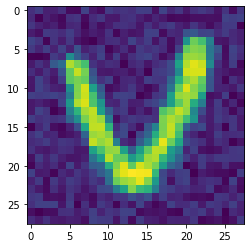

In [5]:
#Showing a random EMNIST image, run this cell again and again to inspect random images in the dataset.
# x[0] is just enumerate number
# x[1] is a single batch of data, x[1][1] is a batch of labels, x[1][0][4] is the fourth image in a batch
idx = random.randint(0,99)
x = next(enumerate(train_loader))
lbl = x[1][1][idx]
img = (x[1][0][idx] + torch.rand(1, 1, 28, 28)/2).reshape(28,28)  #+ torch.rand(28,28)/2

print("letter:", "ABCDEFGHIJKLMNOPQRSTUVWXYZ"[lbl]) 
plt.imshow(img)

In the following block, we define our own layers for the CNN-F.

We will be requiring a forward layer, for the forward pass to generate the output label y, and a backward layer, for the backward pass which should regenerate the original image features. 

While training, for each batch, we first have a forward pass and one backward pass for each cycle.

If we have initialised the number of cycles to 2, this means that each input image x is encoded to input features h, and passes through the model to generate an image label y. Then this y is send 'backwards' through the CNNF to regenerate the image features h'. 

Then h' is send forwards again, to generate another y, which is sent backwards to generate another set of input features h''.

For each batch iteration, we send a batch of clean images and a batch of noisy images to the model.

The loss function is calulated by taking five things into consideration: 
1. The cross entropy loss between the logits generated by the forward pass of the model and the actual logits of the image.
2. The MSE loss between the reconstructed features of noisy images (h' for the noisy images, generated by the backward pass) and the original features of the image (h of the clean images, present before the last forward pass).
3. The MSE loss between the block 1 features of the noisy images (generated by the backward pass) and the block 1 features of the clean images (generated by the forward pass). 
4. The MSE loss between the block 2 features of the noisy images (generated by the backward pass) and the block 2 features of the clean images (generated by the forward pass). 
5. The cross entropy loss between the logits generated by the backward pass of the model and the actual logits of the image.

The block 1 and block 2 are outputs of the intermediate part of the backwards pass: the idea is that the clean and dirty (noisy or adversarial) images should have the same outputs at the intermediate stages.


An example of the feedforward (forward pass) and feedback (backward pass) process for a particular achitecture:
[credits:https://yjhuangcd.github.io/blog/2020/neurips_cnnf/]


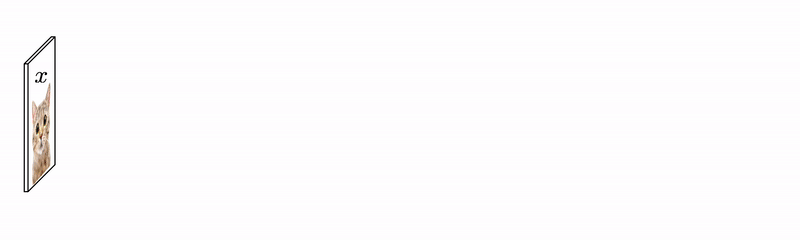


The InS Norm or instance normalisation layer normalises a single instance (and not over all the batched instances). The forward pass just normalises the image by the norm of each channel of the image. The backward pass is the same as forward pass in this respect, therefore we do not need a seperate function for the backward pass.

In [6]:
#LAYER DEFINITIONS (support backward propagations for feedback)
class InsNorm(nn.Module):
    def forward(self, x, std=False, returnnorm=False):
        if (std==True):
          #use sqrt(variance) for the norm
            normx = torch.sqrt(torch.var(x, dim=(2,3)).reshape([x.shape[0],x.shape[1],1,1]) + 1e-8)
        else:
          #use sqrt(mean of squares) for the norm
            normx = torch.sqrt(torch.mean(x**2, dim=(2,3)).reshape([x.shape[0],x.shape[1],1,1]) + 1e-8)
        if returnnorm==True: 
            return x/normx, normx
        else:
            return x/normx


The Flatten module flattens the input into a vector.
The backward pass turns the flattened vector back into its original form, by saving the original size of the input.

In [7]:
class Flatten(nn.Module):
    def forward(self, x, step='forward'):
        if 'forward' in step:
            self.size = x.size() #original size of the input is saved
            batch_size = x.size(0)
            return x.view(batch_size, -1) #returning flattened input to the forward pass

        elif 'backward' in step:
            batch_size = x.size(0)
            return x.view(batch_size, *self.size[1:])

        else:
            raise ValueError("step must be 'forward' or 'backward'")
            

The Conv2D module applies a 2D convolution over the input for the forward pass. 
In the backward pass of the module, a transposed 2D convolution is applied to the input with the same weights as the original 2D convolution.

This module uses a He initialisation for the weights, which is a modified version of the Xavier initialisation that developed specially for nodes and layers that use the ReLu activation.

The He initialization method is calculated as a random number with a Gaussian probability distribution (G) with a mean of 0.0 and a standard deviation of sqrt(2/n), where n is the number of inputs to the node.


In [8]:
class Conv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, bias=False, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              bias=bias, **kwargs)
        
        if self.conv.stride[0] > 1:  #if the stride of the convolution is greater than 1, we enable padding
            self.conv_t = nn.ConvTranspose2d(out_channels, in_channels,
                                         kernel_size, bias=bias, output_padding=1, **kwargs) #the transposed 2D convolution
        else: #if the stride is just 1, we do not need to enable padding.
            self.conv_t = nn.ConvTranspose2d(out_channels, in_channels,
                                         kernel_size, bias=bias, **kwargs)
        
        #The following part of the code uses the He initialisation for the weights of the convolutional layer
        n = self.conv.kernel_size[0] * self.conv.kernel_size[1] * self.conv.out_channels #no of inputs to the node is the size of the kernel into the number of kernel channels
        self.conv.weight.data.normal_(0, math.sqrt(2. / n)) #Mean 0, stddev sqrt (2/n) 
        
        #Tie the weights between the convolution and the transposed convolution
        self.conv_t.weight = self.conv.weight

    def forward(self, x, step='forward'):
        if 'forward' in step:
            return self.conv(x) #return the normal convolution

        elif 'backward' in step:
            return self.conv_t(x) #return the transposed convolution

        else:
            raise ValueError("step must be 'forward' or 'backward'")
            

The Linear class applies a linear transformation to the input in the forward pass. 
THe backward pass involves applying a transposed version of the same linear transform (with corresponding transposed weights) to the input.

In [9]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=False, **kwargs):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias) #our forward pass linear transform 
        self.linear_t = nn.Linear(out_features, in_features, bias=bias) #the transposed version of the above linear transform: note the no of input and output channels is reversed
        
        if(bias==True):
            self.linear.bias.data.zero_() #initialising the bias to 0
        # Tie the weight of the transposed linear transform with the
        # transposed weights of the linear transform
        self.linear_t.weight.data = self.linear.weight.data.t()

        # Make the weight publicly accessible
        self.weight = self.linear.weight

    def forward(self, x, step='forward'):
        if 'forward' in step:
            return self.linear(x)

        elif 'backward' in step:
            # Tie the weight of the transposed linear transform with the
            # transposed weights of the linear transform
            self.linear_t.weight.data = self.linear.weight.data.t()
            return self.linear_t(x) #returning the transposed linear transform 

        else:
            raise ValueError("step must be 'forward' or 'backward'")
            

This class applies the standard ReLU activation over the input. 

It saves the state of variables, to keep track of which inputs were activated. This will let only inputs that were activated in the forward pass, pass through in the backward pass.

In [10]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.state = None #keeps track of whether an input was activated or not 
        self.hidden = None

    def forward(self, x, null_space=None, unit_space=None, step='forward'):
        if 'forward' in step:
            # Store which weights were activated
            if self.hidden is None: #this is the first forward pass
                self.state = (x > 0)  #stores the state of the input (ie whether it was activated or not : if its greater than 0, then reLU activates it)     
            else:
                self.state = (x * self.hidden) > 0 #if this is not the first forward pass, takes value of the input multiplied with the previous value passed through the ReLU backward pass
            result = x * self.state.float() #the relu function
                
            return result

        elif 'backward' in step:
            # Units that were activated in the forward step are passed through
            self.hidden = x #stores the value that is being passed through, to be used in the next forward pass
            masked_hidden = x * self.state.float() #the relu function
            if unit_space is not None:
                return masked_hidden, unit_space
            else:
                return masked_hidden

        else:
            raise ValueError("step must be 'forward' or 'backward'")

    def reset(self):
        self.hidden = None
        self.state = None
        

This class applies the ReLU activation with residual updates over the input.

It saves the state of variables, to keep track of which inputs were activated. This will let only inputs that were activated in the forward pass, pass through in the backward pass.

In [11]:

        
class resReLU(nn.Module):
    """
    AdaReLU with residual updates.
    """
    def __init__(self, res_param = 0.1):
        super().__init__()
        self.state = None
        self.hidden = None
        self.res_param = res_param #this is the residual parameter

    def forward(self, x, null_space=None, unit_space=None, step='forward'):
        if 'forward' in step:
            # Store which weights were activated
            if self.hidden is None:  #this is the first forward pass
                self.state = (x > 0)   #stores the state of the input (ie whether it was activated or not : if its greater than 0, then reLU activates it)                 
            else: #NOT the first forward pass: there was a backward pass before this
                x = x + self.res_param * (self.hidden - x) #the residual parameter comes into play here: self.hidden is the last value that was passed through the ReLU backward pass
                #thus, the difference between the last value passed through the reLU backward pass and the current input value is multiplied with the residual parameter and added to the input
                self.state = (x * self.hidden) > 0 #if this is not the first forward pass, takes value of the input multiplied with the previous value passed through the ReLU backward pass
            result = x * self.state.float() #the reLU activation function
                
            return result

        elif 'backward' in step:
            # Units that were activated in the forward step are passed through
            self.hidden = x #stores the value that is being passed through, to be used in the next forward pass
            masked_hidden = x * self.state.float()  #the reLU activation function
            if unit_space is not None:
                return masked_hidden, unit_space
            else:
                return masked_hidden

        else:
            raise ValueError("step must be 'forward' or 'backward'")

    def reset(self):
        self.hidden = None
        self.state = None
        

This is the average pool class. The forward pass takes the average value for the values of the feature map. The backward pass tries to reverse this functionality by applying a 2D nearest neighbour upsampling to the input. 

In [12]:
class AvgPool2d(nn.Module):
    
    def __init__(self, kernel_size, scale_factor=10, **kwargs):
        super().__init__()
        
        self.avgpool = nn.AvgPool2d(kernel_size, **kwargs) #applying average pool to the input 
        self.upsample = nn.UpsamplingNearest2d(scale_factor=scale_factor, **kwargs)  # reversing the average pool by performing nearest neighbour upsampling on the input 
        #the scale factor decides the output size of function

    def forward(self, x, step='forward'):
        if 'forward' in step:
            return self.avgpool(x)

        elif 'backward' in step:
            return self.upsample(x)

        else:
            raise ValueError("step must be 'forward' or 'backward'")
            

The MaxPool class performs a maxpooling operation over the input in the forward pass in the following manner:
If the pixel in g that governs this grid is > 0, it performs maxpool on this grid.
If the pixel in g that governs this grid is < 0, it performs min pool on this grid.

For the backward pass, we use MaxUnpool2d which takes in as input the output of MaxPool2d including the indices of the maximal values and computes a partial inverse in which all non-maximal values are set to zero. 

Thus, it keeps track of whether the pixel came from a min value or a max value pooling. If it came from a min value pooling, we put it back in the position of the min value. If it came from a max value pooling, we put it back in the position of the max value.


In [13]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size, **kwargs):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size, return_indices=True, **kwargs) #the maxpool layer 
        self.unpool = nn.MaxUnpool2d(kernel_size, **kwargs) #the reverse maxpool layer for the backward pass, computes inverse of the maxpool layer output by setting all non maximal values to zero
        
        self.hidden = None #to record the value of the prev backward pass input for the next forward pass
        self.pos_state = None #checks if the hidden state (the value of the last backward pass) is greater than 0
        self.neg_state = None #checks if the hidden state (the value of the last backward pass) is less than 0
        self.pos_ind = None #records the indices of the maximum elements in the original input which are output after performing maxpooling
        self.neg_ind = None #records the indices of the minimum elements in the original input which are output after performing minpooling 
        self.unpoolsize = None #records the shape of the input in the forward pass

    def forward(self, x, null_space=None, unit_space=None, step='forward'):
        if 'forward' in step:
            if self.hidden is None: #first forward pass
                self.unpoolsize = x.shape #records the shape of the input in the forward pass
                max_pool, self.pos_ind = self.maxpool(x)   # self.pos_ind returns the indices of the maximum elements in the original input
                return max_pool
                
            else: #not the first forward pass, we may need to deal with negative input
                max_pool, self.pos_ind = self.maxpool(x) #maxpools input, records indices of max elements
                min_pool, self.neg_ind = self.maxpool(-x) #effectively minpools input, records indices of min elements 
                min_pool = -min_pool #need to reverse the sign to get the correct value of the minpool output
                self.pos_state = (self.hidden > 0).float() #checks if the hidden state (the value of the last backward pass) is greater than 0
                self.neg_state = (self.hidden < 0).float() #checks if the hidden state (the value of the last backward pass) is less than 0
                out = self.pos_state * max_pool + self.neg_state * min_pool #if we perform maxpool, we return maxpool output. if we perform minpool, we return minpool output. 
                #works because pos_state and neg_state are boolean flags
                return out

        elif 'backward' in step:
            self.hidden = x #records input of backward pass for next input pass
            if ((self.pos_state is None) or (self.neg_state is None)):  # this is the first backward pass
                max_unpool = self.unpool(x, self.pos_ind, output_size=self.unpoolsize)  #perform unpool directly since first forward pass always performs maxpooling
                return max_unpool
            else:            
                max_unpool = self.unpool(x * self.pos_state, self.pos_ind, output_size=self.unpoolsize) #performs unpooling on the maxpool output using the positive indices of the forward pass
                min_unpool = self.unpool(x * self.neg_state, self.neg_ind, output_size=self.unpoolsize) #performs unpooling on the minpool output using the negative indices of the forward pass
                return max_unpool + min_unpool #can only return one of them, since x*self.pos_state will be 0 if self.neg_state is 1 and thus give max_unpool the value of 0 and vice versa

        else:
            raise ValueError("step must be 'forward' or 'backward'")

    def reset(self):
        self.hidden = None
        self.pos_state = None
        self.neg_state = None
        self.pos_ind = None
        self.neg_ind = None
        

The bias class just adds bias to the input in the forward pass, and subtracts it in the backward pass.

In [14]:
class Bias(nn.Module):

    def __init__(self, size):
        super().__init__()
        self.bias = nn.Parameter(torch.Tensor(*size)) #bias is a parameter
        self.bias.data.zero_() #setting the bias value to zero

    def forward(self, x, step='forward'):
        if 'forward' in step:
            return x + self.bias #adding the bias to the input

        # no bias in backwards pass
        elif 'backward' in step:
            self.x = x
            return x - self.bias #returning the bias 

        else:
            raise ValueError("step must be 'forward' or 'backward'")

    def path_norm_loss(self, unit_space):
        return torch.mean((self.x * self.bias - unit_space * self.bias)**2)
        

The Dropout class performs dropout regularisation (setting the input values to 0 with a probability p) on the input for the forward pass and stores whether the values of the input have been set to zero or not. 

In the backward pass, if the corresponding input values for the forward pass were set to 0 then the backward pass values are also set to 0. Otherwise, they are let through.


In [15]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p #probability with which backward pass is performed

    def forward(self, x, step='forward'):
        if 'forward' in step:
            if self.training: #we dont perform dropout operations in the testing stage, only in the training stage 
                self.dropout = (torch.rand_like(x) > self.p).float() / self.p  #recording whether the input was dropped out or not. if random number is less than p, then the input is dropped
                #we divide by self.p so that sum over all inputs is unchanged
                return x * self.dropout #if self.dropout is 0, then x*self.dropout will also be 0
            else:
                return x #do not drop any inputs if the model is testing

        elif 'backward' in step:
            if self.training: #we dont perform dropout operations in the testing stage, only in the training stage 
                return x * self.dropout #performing the same operation on the backward pass as was done in the forward pass
                #if x was dropped in the forward pass, it will be dropped in the backward pass
                #if x was let through in the forward pass, it will be let through in the backward pass
            else:
                return x #do not drop any inputs if the model is testing

        else:
            raise ValueError("step must be 'forward' or 'backward'")

In [16]:
#@title cnnf
#https://github.com/yjhuangcd/CNNF/blob/main/train.py

In [17]:
from torch._C import BenchmarkExecutionStats
class myCNNF(nn.Module):
    #2 convolutions, 2 linear layers
    def __init__(self, num_classes, ind=0, cycles=2, res_param=0.1):
        super(myCNNF, self).__init__()
        
        self.ind = ind #index to set the maximum backwards layer where the feedforward feedback loop cycles to: we set it to 0 so the data passes through all the layers
        self.res_param = res_param #res_param for the reLU with residual updates
        self.cycles = cycles #number of back and forth passes 
        
        #28x28x16
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False) 
        self.ins1 = InsNorm()
        self.ins1_bias = Bias((1,32,1,1))
        self.relu1 = resReLU(res_param)
        self.maxpool1 = MaxPool2d(2)
        #14x14x32
        self.conv2 = Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.ins2 = InsNorm()
        self.ins2_bias = Bias((1,16,1,1))
        self.relu2 = resReLU(res_param)
        self.maxpool2 = MaxPool2d(2)
        #7x7x16

        self.flatten = Flatten()
        self.fc1 = Linear(7*7*16, 256)
        self.fc1_bias = Bias((1,256))
        self.relu3 = resReLU(res_param) 
        self.fc2 = Linear(256, num_classes)
        self.fc2_bias = Bias((1,num_classes))
        #1x26

    def forward(self, out, step='forward', first=True, inter=False, inter_recon=False):     
        if ('forward' in step):
            orig_feature = out #saving the original features
      

            block1 = out = self.relu1(self.ins1_bias(self.ins1(self.conv1(out))))   #intermediate block 1         
            out = self.maxpool1(block1) #maxpool of block 1

            block2 = out = self.relu2(self.ins2_bias(self.ins2(self.conv2(out)))) #intermediate block 2     
            out = self.maxpool2(block2) #maxpool of block 2
           
            out = self.flatten(out) #flattening the input
            out = self.relu3(self.fc1_bias(self.fc1(out)))   #linear layer, then bias layer, then relu   
            out = self.fc2_bias(self.fc2(out)) #final output after a linear and bias layer

        elif ('backward' in step):

            out = self.fc2(out, step='backward') #backward computation of all forward pass steps
            out = self.relu3(out, step='backward')
            out = self.fc1(out, step='backward')
            out = self.flatten(out, step='backward')

            out = self.ins2(out)
            out = self.maxpool2(out, step='backward')
            out = self.relu2(out, step = 'backward')
            block2_recon = out   #getting the block 2 output (since block 2 occurs after block 1 in forward pass, it occurs before block 1 in the backward pass)         
            
            out = self.conv2(out, step='backward')
            out = self.ins1(out)
            out = self.maxpool1(out, step = 'backward')
            out = self.relu1(out, step='backward')
            block1_recon = out #block 1 output of backward pass

            out = self.conv1(out, step='backward') #getting the final output
      

            
        if (inter==True) and ('forward' in step):
            return out, orig_feature, block1, block2 #we return the final output of the backward pass, original features, and intermediate block1 and block2 output
        elif (inter_recon==True) and ('backward' in step):
            return out, block1_recon, block2_recon #we return the final output of the backward pass and intermediate block1 and block2 output
        else:
            return out #only output of backward pass returned

    def reset(self): #resets pooling and activation states
        
        self.maxpool1.reset()
        self.maxpool2.reset()
        self.relu1.reset()
        self.relu2.reset()
        self.relu3.reset()
        

    def run_cycles(self, data):
        # evaluate with all the iterations
        with torch.no_grad():
            data = data.cuda()
            self.reset()
            output, orig_feature, _, _ = self.forward(data, first=True, inter=True) #getting the output and the original features of the forward pass
            ff_prev = orig_feature #saving the original features as the feedforward reconstructions
            for i_cycle in range(self.cycles): 
                reconstruct = self.forward(output, step='backward') #getting the reconstructions from the backward step
                ff_current = ff_prev + self.res_param * (reconstruct - ff_prev)  #updating the previous forward pass reconstructions with the difference of the backward pass reconstructions and the previous recontructions into reesidual parameter
                output = self.forward(ff_current, first=False) #sending this in to the forward pass and getting output
                ff_prev = ff_current #saving the forward pass output

        return output
        
    def run_cycles_adv(self, data):
        data = data.cuda()
        self.reset()
        output, orig_feature, _, _ = self.forward(data, first=True, inter=True) #getting the output logits and the original features of the forward pass
        ff_prev = orig_feature #saving the original features as the feedforward reconstructions
        for i_cycle in range(self.cycles):
            reconstruct = self.forward(output, step='backward')  #getting the reconstructions from the backward pass
            ff_current = ff_prev + self.res_param * (reconstruct - ff_prev) #updating the previous forward pass reconstructions with the difference of the backward pass reconstructions and the previous recontructions into reesidual parameter
            output = self.forward(ff_current, first=False)  #sending this in to the forward pass and getting output logits
            ff_prev = ff_current  #saving the forward pass output
        return output

    def run_average(self, data):
        # return averaged logits
        data = data.cuda() 
        self.reset()
        output_list = []
        output, orig_feature, _, _ = self.forward(data, first=True, inter=True) #getting the outputs from forward pass
        ff_prev = orig_feature
        output_list.append(output)
        totaloutput = torch.zeros(output.shape).cuda()
        for i_cycle in range(self.cycles):
            reconstruct = self.forward(output, step='backward') #getting the reconstructions from the backward pass
            ff_current = ff_prev + self.res_param * (reconstruct - ff_prev) #updating the previous forward pass reconstructions with the difference of the backward pass reconstructions and the previous recontructions into reesidual parameter
            ff_prev = ff_current #saving the forward pass output
            output = self.forward(ff_current, first=False)  #sending this in to the forward pass and getting output logits
            output_list.append(output) #saving the output logits
        for i in range(len(output_list)):
            totaloutput += output_list[i] #adding up all the final output logits
        return totaloutput / (self.cycles+1) #taking average of all logits
    
    def forward_adv(self, data):
        # run the first forward pass
        data = data.cuda()
        self.reset()
        output = self.forward(data)
        return output

In [18]:
class myCNN(nn.Module):
    #2 convolutions, 2 linear layers
    #This is a vanilla CNN to compare the CNN-F against
    #it has the same architecture
    def __init__(self, num_classes,res_param=0.1):
        super(myCNN, self).__init__()
        
       
        self.res_param = res_param
        self.cycles = cycles        
        
        #28x28x16
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.ins1 = InsNorm()
        self.ins1_bias = Bias((1,32,1,1))
        self.relu1 = resReLU(res_param)
        self.maxpool1 = MaxPool2d(2)
        #14x14x32
        self.conv2 = Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.ins2 = InsNorm()
        self.ins2_bias = Bias((1,16,1,1))
        self.relu2 = resReLU(res_param)
        self.maxpool2 = MaxPool2d(2)
        #7x7x16

        self.flatten = Flatten()
        self.fc1 = Linear(7*7*16, 256)
        self.fc1_bias = Bias((1,256))
        self.relu3 = resReLU(res_param) 
        self.fc2 = Linear(256, num_classes)
        self.fc2_bias = Bias((1,num_classes))
        #1x26

    def forward(self, out):     
        out = self.relu1(self.ins1_bias(self.ins1(self.conv1(out))))            
        out = self.maxpool1(out)

        out = self.relu2(self.ins2_bias(self.ins2(self.conv2(out))))
        out = self.maxpool2(out)
        
        out = self.flatten(out)
        out = self.relu3(self.fc1_bias(self.fc1(out)))       
        out = self.fc2_bias(self.fc2(out))

        return out


    def reset(self):
        """
        Resets the pooling and activation states
        """
        self.maxpool1.reset()
        self.maxpool2.reset()
        self.relu1.reset()
        self.relu2.reset()
        self.relu3.reset()
    

In [19]:
model = myCNNF(26).to(device) #initialising CNNF model with number of classes
optimizer = torch.optim.SGD(
          model.parameters(),
          learning_rate, #lr
          momentum=_momentum,
          weight_decay= _weight_decay) #stochastic gradient descent optimizer with learning rate, momentum, weight decay


def lr_poly(base_lr, iter, max_iter, power):
    return base_lr * ((1 - float(iter) / max_iter) ** (power)) #learning rate polynomial

#learning rate scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR( 
          optimizer, lr_lambda=lambda step: lr_poly(1.0, step, 2 *num_epochs * len(train_loader), _scheduler_poly_exponent)) 

 #initialising CNN model with number of classes
modelCNN = myCNN(26).to(device)
optimizerCNN = torch.optim.SGD(
          modelCNN.parameters(),
          learning_rate, #lr
          momentum=_momentum, #stochastic gradient descent optimizer with learning rate, momentum, weight decay
          weight_decay= _weight_decay)
#learning rate scheduler
schedulerCNN =  torch.optim.lr_scheduler.LambdaLR(
          optimizer, lr_lambda=lambda step: lr_poly(1.0, step, 2 *num_epochs * len(train_loader), _scheduler_poly_exponent)) #using the learning rate polynomial equation in scheduler


In [20]:
def test_clean(model, test_loader):
  cmatrix_clean = np.zeros((26,26)) #Confusion matrix for clean images fed to CNN-F
  model.eval() #freezing weights, stopping dropout
  correct_clean = 0 #counting the number of images
  with torch.no_grad():
    for batch_idx, (images, targets) in (enumerate(test_loader)): #we go batch by bacth
      images, targets = images.to(device), targets.to(device) 
      output = model.run_cycles(images) #getting the output from the model
      pred = output.argmax(dim=1, keepdim = True) #counting correct outputs
      correct_clean += pred.eq(targets.view_as(pred)).sum().item() #adding up the correct predictions
      for x, y in zip(pred, targets): # for all samples in batch, we add to the heatmap square corresponding to [prediction][actual label]
          cmatrix_clean[x][y] += 1

  print("Clean acc for CNN-F: ", correct_clean / len(test_loader.dataset))
  print("Confusion matrix for CNN-F on clean images:")
  plt.imshow(cmatrix_clean)

def test_clean_CNN(modelCNN, test_loader):
  cmatrix_clean_CNN = np.zeros((26,26)) #Confusion matrix for clean images fed to CNN
  modelCNN.eval() #freezing weights, stopping dropout
  correct_clean = 0 #counting the number of images
  with torch.no_grad():
    for batch_idx, (images, targets) in (enumerate(test_loader)):  #we go batch by bacth
      images, targets = images.to(device), targets.to(device)
      output = modelCNN(images) #getting the output from the model
      pred = output.argmax(dim=1, keepdim = True)
      correct_clean += pred.eq(targets.view_as(pred)).sum().item()  #adding up the correct predictions
      for x, y in zip(pred, targets): # for all samples in batch, we add to the heatmap square corresponding to [prediction][actual label]
          cmatrix_clean_CNN[x][y] += 1

  print("Clean acc for CNN: ", correct_clean / len(test_loader.dataset))
  print("Confusion matrix for CNN on clean images:")
  plt.imshow(cmatrix_clean_CNN)


def test_noisy(model, test_loader):
  cmatrix_noisy = np.zeros((26,26)) #Confusion matrix for noisy images fed to CNN-F
  model.eval() #freezing weights, stopping dropout
  correct_noisy = 0 #counting the number of images
  with torch.no_grad():
    for batch_idx, (images, targets) in (enumerate(test_loader)):  #we go batch by bacth
      images, targets = images.to(device), targets.to(device)
      noise = torch.rand(test_batch_size, 1, 28, 28) / random_noise_divisor #creating noisy images by adding noise
      noisy_images = images  + noise.to(device)
      output = model.run_cycles_adv(noisy_images) #getting the output from the model
      pred = output.argmax(dim=1, keepdim = True)
      correct_noisy += pred.eq(targets.view_as(pred)).sum().item()  #adding up the correct predictions
      for x, y in zip(pred, targets): # for all samples in batch, we add to the heatmap square corresponding to [prediction][actual label]
          cmatrix_noisy[x][y] += 1

  print("Noisy acc for CNN-F: ", correct_noisy / len(test_loader.dataset))
  print("Confusion matrix for CNN-F on noisy images:")
  plt.imshow(cmatrix_noisy)

def test_noisy_CNN(model, test_loader):
  cmatrix_noisy_CNN = np.zeros((26,26)) #Confusion matrix for noisy images fed to CNN-F
  model.eval() #freezing weights, stopping dropout
  correct_noisy = 0 #counting the number of images
  with torch.no_grad():
    for batch_idx, (images, targets) in (enumerate(test_loader)):  #we go batch by bacth
      images, targets = images.to(device), targets.to(device)
      noise = torch.rand(test_batch_size, 1, 28, 28) / random_noise_divisor #creating noisy images by adding noise
      noisy_images = images  + noise.to(device)
      output = model(noisy_images) #getting the output from the model
      pred = output.argmax(dim=1, keepdim = True)
      correct_noisy += pred.eq(targets.view_as(pred)).sum().item()  #adding up the correct predictions
      for x, y in zip(pred, targets): # for all samples in batch, we add to the heatmap square corresponding to [prediction][actual label]
          cmatrix_noisy_CNN[x][y] += 1

  print("Noisy acc for CNN: ", correct_noisy / len(test_loader.dataset))
  print("Confusion matrix for CNN on noisy images:")
  plt.imshow(cmatrix_noisy_CNN)

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()                    #gradient sent through the signum function 
    perturbed_image = image + epsilon*sign_data_grad     #how we add noise to the image
    perturbed_image = torch.clamp(perturbed_image, 0, 1) #image has to stay between 0 and 1 (black and white)
    return perturbed_image




  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Clean acc for CNN:  0.885576923076923
Confusion matrix for CNN on clean images:
Clean acc for CNN:  0.9145604395604395
Confusion matrix for CNN on clean images:
Clean acc for CNN:  0.9174450549450549
Confusion matrix for CNN on clean images:
Clean acc for CNN:  0.923695054945055
Confusion matrix for CNN on clean images:
Clean acc for CNN:  0.9227335164835165
Confusion matrix for CNN on clean images:


<All keys matched successfully>

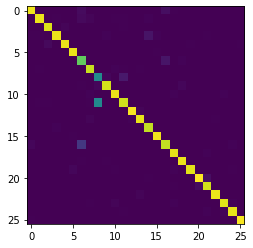

In [21]:
#TRAIN LOOP FOR TRAINING THE NORMAL CNN MODEL
tlosses=[]
vlosses=[]
for epoch in tq.tqdm(range(5)):
  modelCNN.train() #unfreezing weights, enabling dropout
  for batch_idx, (images, targets) in (enumerate(train_loader)): #going through the train dataset, batch by batch

    images, targets = images.to(device), targets.to(device) #moving the data and the labels (or targets) to device (either cpu or cuda)
    optimizerCNN.zero_grad() #zeroes out gradients
    modelCNN.reset() #hidden/state variables reset every time before new data is fed forward in this epoch

    logits = modelCNN(images) #getting the output logits from the model
    loss = F.cross_entropy(logits, targets) #using cross entropy function to calculate the loss
    tlosses.append(loss.item()) #recording the loss of each batch
    loss.backward() #calculating gradients
    optimizerCNN.step() #updating parameters
    schedulerCNN.step() #updating scheduler

  test_clean_CNN(modelCNN, test_loader) #testing against clean images 

torch.save(modelCNN.state_dict(), "./cnn7epoch") #saves the weights 
modelCNN.load_state_dict(torch.load("./cnn7epoch")) #loading back the saved model weights


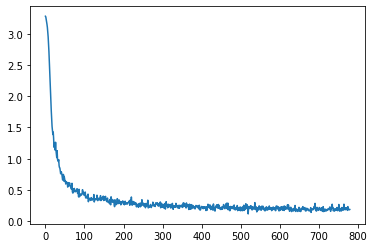

In [22]:
plt.plot(tlosses) #training losses of each batch for the CNN

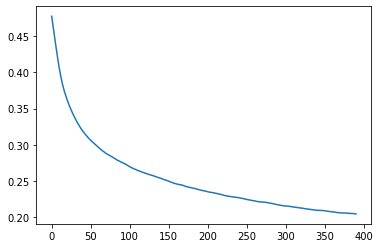

In [23]:
tlosses_moving=np.convolve(tlosses, np.ones(int(len(tlosses)/2))/(int(len(tlosses)/2)), mode='valid')
plt.plot(tlosses_moving) #moving average of training losses

In [24]:
#TRAIN LOOP FOR CNNF
model.train() #unfreezing weights, enabling dropout
model.reset() #resetting the model

correct = 0
train_loss = 0.0
tlosses=[] #collecting training losses
  

for epoch in tq.tqdm(range(num_epochs)):
  for batch_idx, (images, targets) in (enumerate(train_loader)):

    images, targets = images.to(device), targets.to(device) #moving the data and the labels (or targets) to device (either cpu or cuda)
    noise = torch.rand(train_batch_size, 1, 28, 28) / random_noise_divisor  #generating random noise and dividing it appropriately 
    noisy_images = images  + noise.to(device) #generating noise images
    images_all = torch.cat((images, noisy_images), 0) #images followed by noisy images

    optimizer.zero_grad()
    model.reset() #hidden/state variables reset every time before new data is fed forward in this epoch

    logits, orig_feature_all, block1_all, block2_all = model(images_all, first=True, inter=True) #the model returns the logits of the clean and noisy images, the original features, and two output blocks
    ff_prev = orig_feature_all #keeping track of the original features

    orig_feature, _ = torch.split(orig_feature_all, images.size(0))  #taking original features of only clean images
    block1_clean, _ = torch.split(block1_all, images.size(0))  #keeping the block1 output of only clean images
    block2_clean, _ = torch.split(block2_all, images.size(0))  #keeping the block2 output of only clean images 
    
    logits_clean, logits_adv = torch.split(logits, images.size(0)) #getting the clean and noisy image logits 

    loss = F.cross_entropy(logits_adv, targets) / (cycles+1) #cross entropy loss for the noisy images, divided by number of cycles
    
    for i_cycle in range(cycles):
          recon, block1_recon, block2_recon = model(logits, step='backward', inter_recon=True) #getting the outputs from the backwards step: reconstructions, block 1 recons, block 2 recons (output of intermediate part of model)
          recon_clean, recon_adv = torch.split(recon, images.size(0)) #splitting the reconstructions into clean and noisy image reconstruction 
          recon_block1_clean, recon_block1_adv = torch.split(block1_recon, images.size(0)) #splitting the block 1 reconstructions into clean and noisy image reconstruction 
          recon_block2_clean, recon_block2_adv = torch.split(block2_recon, images.size(0)) #splitting the block 2 reconstructions into clean and noisy image reconstruction 

          loss += (F.mse_loss(recon_adv, orig_feature) + F.mse_loss(recon_block1_adv, block1_clean) + F.mse_loss(recon_block2_adv, block2_clean)) * 1 / (3*cycles) #adding all the losses, dividing by the number of cycles

          ff_current = ff_prev + res_parameter * (recon - ff_prev) #output of the feedforward (forward pass) becomes the output of the last forward pass plus the [cont.]
          #[cont.] residual parameter into the difference between the last forward pass output and the current backward pass output
          logits = model(ff_current, first=False) #getting the logits from this new output
          ff_prev = ff_current #setting the previous feedforward pass output to this output
          logits_clean, logits_adv = torch.split(logits, images.size(0)) #splitting the logits for the clean and dirty images

          loss += F.cross_entropy(logits_adv, targets) / (cycles+1) #adding the cross entropy loss of the predicted noisy image outputs with the actual targets
    tlosses.append(loss.item()) #recording the loss of each batch
    pred = logits_clean.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item() #counting correct predictions

    loss.backward()  #calculating gradients
    optimizer.step() #updating parameters
    scheduler.step() #updating scheduler 

    train_loss += loss.item() #adding the current loss to the train loss

torch.save(model.state_dict(), "./cnnf5epoch")   
model.load_state_dict(torch.load("./cnnf5epoch"))


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


<All keys matched successfully>

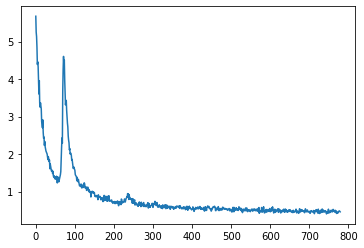

In [25]:
plt.plot(tlosses) #training losses of each batch for CNN-F

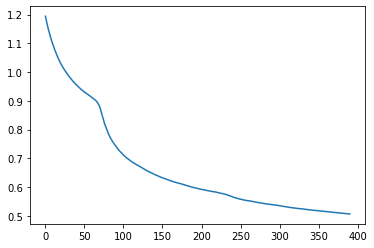

In [26]:
tlosses_moving=np.convolve(tlosses, np.ones(int(len(tlosses)/2))/(int(len(tlosses)/2)), mode='valid')
plt.plot(tlosses_moving) #moving average of training losses

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Clean acc for CNN-F:  0.7800824175824176
Confusion matrix for CNN-F on clean images:


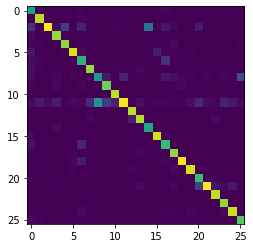

In [27]:
test_clean(model, test_loader) #confusion matrix of CNN-F on clean images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Clean acc for CNN:  0.9230769230769231
Confusion matrix for CNN on clean images:


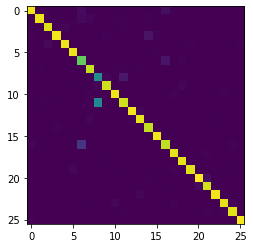

In [28]:
test_clean_CNN(modelCNN, test_loader) #confusion matrix of CNN on clean images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Noisy acc for CNN-F:  0.8882554945054945
Confusion matrix for CNN-F on noisy images:


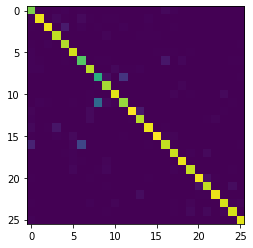

In [29]:
test_noisy(model, test_loader) #confusion matrix of CNN-F on noisy images

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Noisy acc for CNN:  0.8399725274725275
Confusion matrix for CNN on noisy images:


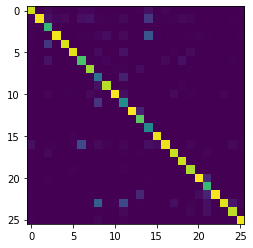

In [30]:
test_noisy_CNN(modelCNN, test_loader) #confusion matrix of CNN-F on noisy images